# Establishing a Good Distance Between Flu Sequences

First we need to establish the meaning of a distance between Influenza sequences. We will look at a special subset of the data where we know roughly what the similarity/distance is bewtween a pair. 

## Jaccard with k-grams

We will run k-grams and bag of "words" on the sequences and cross validate and see if the ones who are similar match our domain knowledge/possible labels. This will tell us if we have a good representation.

In [1]:
import pickle
import gzip
import numpy as np
import pandas as pd
import numba
from collections import Counter
from itertools import product
from FASTA_parse import sequence

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn')

In [3]:
# read in the sequences
with gzip.open('influenza.fna.pklz', 'rb') as fin:
    fna = pickle.load(fin)

In [4]:
fna_meta, fna_seq = fna.get_dataframe()

There are several duplicate sequences so we will remove them because they are irrelevent. It does not matter which one we keep either.

In [5]:
fna_seq.drop_duplicates(subset='Sequence', inplace=True)

Now we need to define a way of tokenizing the sequences so that we can create a word count vector. We also need to generate a dictionary that hold all the possible "words".

We generate the vectors on a sample of the data of size 1000.

### Using a library
We will now use a library from sklearn that will accomplish the same thing, but it is vectorized. This means we can easily increase our sample from 1000 to 10000. Then we will use a KMeans library to cluster them. If we want to use a different distance (e.g. cosine distance) we would have to implement our own clustering.

In [6]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
k=6
sample = fna_seq.sample(10000)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(k-2,k+1))
X = vectorizer.fit_transform(sample.Sequence.tolist())

Note: We can also use a vector that has more than k-gram tokens, e.g. we can use $k=5,6$.

In [8]:
# the sequences have some characters that don't hold very much information so we filter them out entirely.
import re
idxs = []
for i,token in enumerate(vectorizer.get_feature_names()):
    if re.match('^[actg]+$', token):
        idxs.append(i)
        
X = X.toarray()[:,idxs]

### KMeans
Now we will attempt to run KMeans on our now generated vectors. We will look at the cost and see where k should be. We will most likely need to do some dimensionality reduction to improve our performance.

In [9]:
# MiniBatchKMeans!!
inert = np.zeros(shape=(20-2))

for k in range(2,20):
    km = MiniBatchKMeans(k, max_iter=500, batch_size=1000)
    km.fit_predict(X)
    inert[k-2] = km.inertia_
    print(km.inertia_)
    
inert

69550683.6985
62886235.1461
59827642.7724
55431435.5253
53308675.6923
49000736.0169
48032527.7122
45936423.1667
43680910.8435
42987203.3278
41778715.0554
39891602.6443
39130669.0241
37970947.9162
37159653.0791
36206735.9328
34728947.6323
33905469.7005


array([ 69550683.69847333,  62886235.14605667,  59827642.77243479,
        55431435.52528389,  53308675.69234709,  49000736.01694414,
        48032527.71219838,  45936423.16666198,  43680910.84348855,
        42987203.32777783,  41778715.05537793,  39891602.64434244,
        39130669.02407836,  37970947.91615384,  37159653.07907147,
        36206735.9328229 ,  34728947.63232332,  33905469.70053855])

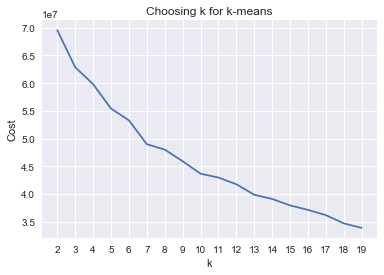

In [10]:
plt.plot(np.arange(2,20,1), inert)
plt.xticks(np.arange(2,20,1))
plt.title('Choosing k for k-means')
plt.xlabel('k')
plt.ylabel('Cost')
plt.show()

Since out KMeans cost was so high we will see if there are actually any clusters by using PCA. We will plot the 1st, 2nd, and 3rd PC's in a 2D plane.

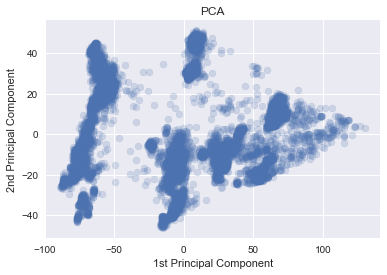

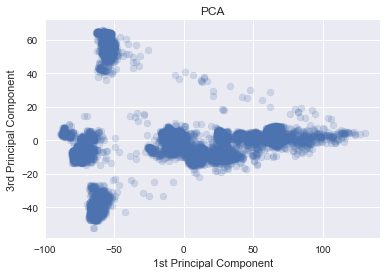

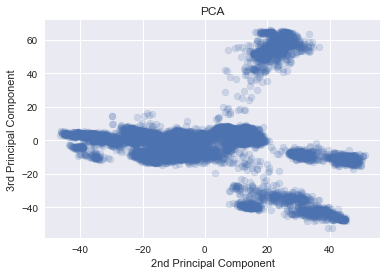

In [11]:
# TODO extract gene type and see if clusters correspond to the different genes
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
new_X = pca.fit_transform(X)

plt.scatter(new_X[:,0], new_X[:,1], alpha=.2)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('PCA')
plt.show()

plt.scatter(new_X[:,0], new_X[:,2], alpha=.2)
plt.xlabel('1st Principal Component')
plt.ylabel('3rd Principal Component')
plt.title('PCA')
plt.show()

plt.scatter(new_X[:,1], new_X[:,2], alpha=.2)
plt.xlabel('2nd Principal Component')
plt.ylabel('3rd Principal Component')
plt.title('PCA')
plt.show()

As we can see there are some very defined clusters. We should be able to approximate our sequence representations very well to a very low dimension. Note that we know there are 8 different gene types, so we expect there to be 8 clusters, but they may not be sharply defined.

### Using PCA to find the best lowest dimension representation
Now we will use PCA just like above to look at the first 10 components and see if it is clusterable. After we do that we will cross validate with some possible known cluster labels to see if our representations are representing the different genes or if it is a new structure.

In [12]:
pca = PCA(n_components=10)
new_X = pca.fit_transform(X)

In [13]:
# MiniBatchKMeans!!
inerts = []
inert = []
kms = []


for n in range(2,11):
    print(n)
for k in range(2,25):
    break
    km = MiniBatchKMeans(k, max_iter=550, batch_size=1000)
    km.fit_predict(new_X)
    inert.append(km.inertia_)
    kms.append(km)
    

2
3
4
5
6
7
8
9
10


ValueError: x and y must have same first dimension, but have shapes (23,) and (0,)

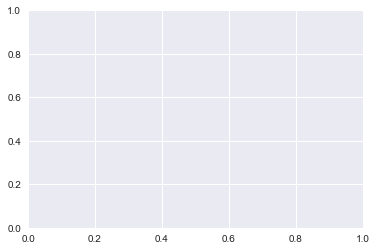

In [14]:
plt.plot(np.arange(2,25,1), inert)
plt.xticks(np.arange(2,25,1))
plt.title('Choosing k for k-means')
plt.xlabel('k')
plt.ylabel('Cost')
plt.show()

In [ ]:
km7 = kms[5]

plt.scatter(new_X[:,0], new_X[:,1], alpha=.5, c=km7.labels_, cmap='Pastel2')
plt.scatter(km7.cluster_centers_[:,0], km7.cluster_centers_[:,1], c='r')
plt.show()

In [ ]:
km7.labels_